These codes serve to convert a HRTEM image into the format that can be processed by the VAEs model, then encode the image into the latent space. The first half of the codes can also be used to prepare a new training dataset for the VAEs model.

In [1]:
#Dependencies
import ncempy.io as nc #Open-NCEM Available at https://openncem.readthedocs.io/en/latest/
from insituanalysis import *
import numpy as np
import matplotlib.pyplot as plt
import cv2
import keras

In [2]:
encoder = keras.models.load_model('Trained VAEs/20220310_b_vae2d_64_b2_addeddepth_gaussian_image_augmented_20epoch_encoder')
decoder = keras.models.load_model('Trained VAEs/20220310_b_vae2d_64_b2_addeddepth_gaussian_image_augmented_20epoch_decoder')

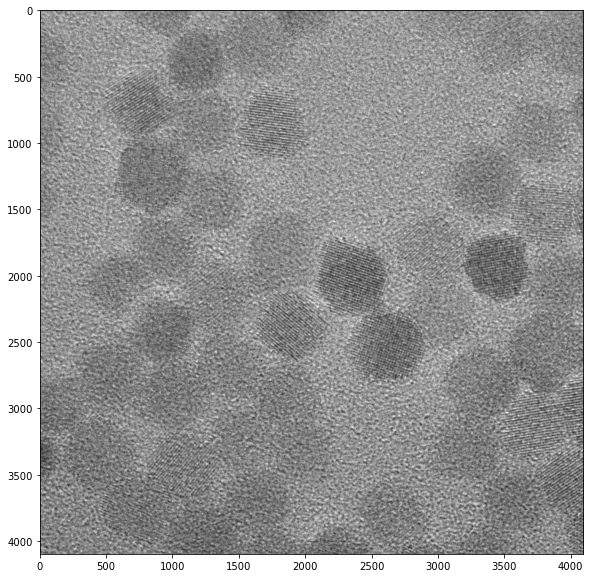

In [3]:
# Loading a .dm4 image
data = nc.read('example.dm4') # Due to Github's file size constrain, we cannot include a sample .dm4 file in this repository. Sample images are available in the Dryad deposit associated with our manuscript.
image = Gaussian_adjust(data['data'])
plt.figure(figsize=(10,10))
plt.imshow(image, cmap='gray')

In [5]:
image.shape[0]

4096

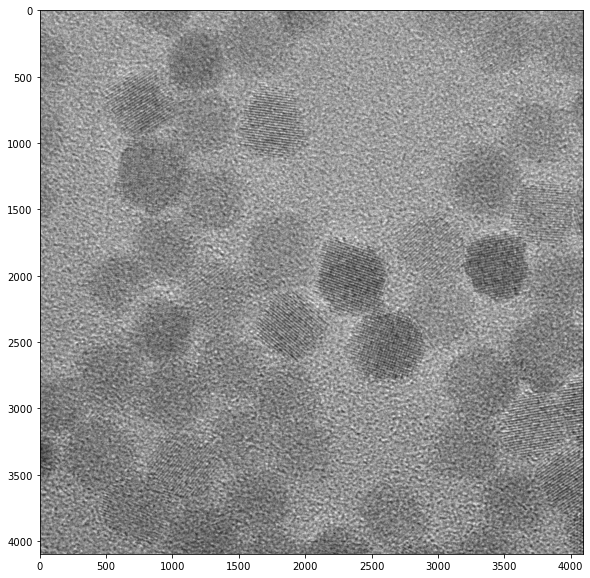

In [7]:
# Performing Gaussian filtering
filter_size = 1024
im_size = image.shape
dft_shift, mag = dfourier(image)
f_ishift = np.fft.ifftshift(dft_shift*np.expand_dims(gaussian2d(im_size, (im_size[0]/2, im_size[0]/2), (filter_size,filter_size)), axis=-1))
im_back = np.abs(cv2.idft(f_ishift))
im_back = cv2.magnitude(im_back[:,:,0],im_back[:,:,1])
plt.figure(figsize=(10,10))
plt.imshow(Gaussian_adjust(im_back), cmap='gray')

In [11]:
# Crops into 64-by-64 pixels segments
sub_crop_size = 32
distance = sub_crop_size*2
grid = np.int(im_size[0]/distance)
crops = list()

for i in range(grid**2):
    center = np.array([sub_crop_size+np.floor(i/grid)*distance, sub_crop_size+np.remainder(i, grid)*distance]).astype('int')
    crop = im_back[center[1]-sub_crop_size:center[1]+sub_crop_size, center[0]-sub_crop_size:center[0]+sub_crop_size]
    crops.append(crop)

crops = np.array(crops)
crops.shape

(4096, 64, 64)

In [18]:
# Encoded into latent space
z_mean,_,_ = encoder.predict(norm(rescale(crops))[:,:,:,np.newaxis])
z_mean = z_mean.reshape((grid,grid,64))

In [19]:
z_mean.shape
# z_mean[X, Y, Z] repsents the Zth latent variable for segment [X, Y] of the original image

(64, 64, 64)